In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold , RandomizedSearchCV,cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.metrics import classification_report,log_loss, roc_auc_score
from sklearn.decomposition import KernelPCA
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import precision_recall_curve 



%matplotlib inline

In [7]:
!pip freeze


alembic==1.12.0
anyio==4.0.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==2.4.0
async-lru==2.0.4
attrs==23.1.0
Babel==2.13.0
backcall==0.2.0
beautifulsoup4==4.12.2
bleach==6.1.0
catboost==1.2.2
certifi==2023.7.22
cffi==1.16.0
charset-normalizer==3.3.0
cloudpickle==3.0.0
colorama==0.4.6
colorlog==6.7.0
comm==0.1.4
contourpy==1.1.1
cycler==0.12.1
debugpy==1.8.0
decorator==5.1.1
defusedxml==0.7.1
et-xmlfile==1.1.0
exceptiongroup==1.1.3
executing==2.0.0
fastjsonschema==2.18.1
fonttools==4.43.1
fqdn==1.5.1
graphviz==0.20.1
greenlet==3.0.0
idna==3.4
ipykernel==6.25.2
ipython==8.16.1
ipython-genutils==0.2.0
ipywidgets==7.6.5
isoduration==20.11.0
jedi==0.19.1
Jinja2==3.1.2
joblib==1.3.2
json5==0.9.14
jsonpointer==2.4
jsonschema==4.19.1
jsonschema-specifications==2023.7.1
jupyter-events==0.7.0
jupyter-lsp==2.2.0
jupyter_client==8.3.1
jupyter_core==5.4.0
jupyter_server==2.7.3
jupyter_server_terminals==0.4.4
jupyterlab==4.0.6
jupyterlab-pygments==0.2.2
jupyterlab-widge

In [3]:
df = pd.read_csv("s_binary.csv")
global_target_col_name = 'Осложнения, возникшие на этапе лечения'
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558 entries, 0 to 1557
Data columns (total 55 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   ОАК_Гемоглобин                                1558 non-null   int64  
 1   ОАК_Гематокрит%                               1558 non-null   int64  
 2   ОАК_Тромбоциты                                1558 non-null   int64  
 3   ОАК_Эритроциты                                1558 non-null   float64
 4   ОАК_Лейкоциты                                 1558 non-null   float64
 5   ОАК_СОЭ                                       1558 non-null   float64
 6   ОАК_Цветовой показатель                       1558 non-null   float64
 7   ОАК_Ретикулоциты                              1558 non-null   float64
 8   ОАК_Тромбокрит %                              1558 non-null   int64  
 9   ОАК_Эозинофилы                                1558 non-null   i

## KNN

In [4]:
df_knn = df[['Общее_Болевой синдром',
         'УЗИ брюшной полости_диурез',
         'УЗИ брюшной полости_объем выпота',
         'Осложнения, возникшие на этапе лечения']]


X = df_knn.drop([global_target_col_name], axis=1)
y = df_knn[global_target_col_name]


In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42, shuffle=True) 

In [199]:
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_jobs=-1))]
)

In [200]:
param_grid = [
    { 'knn__n_neighbors' : [i for i in range(20,40)],
      'knn__weights' : ['uniform','distance'],
      'knn__metric' : ['euclidean','manhattan','cosine'],
    }
]

In [201]:
random_search = RandomizedSearchCV(estimator=knn_pipe, 
                           param_distributions=param_grid, 
                           n_iter=108,
                           scoring='roc_auc', 
                           refit='roc_auc', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=5)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn',
                                              KNeighborsClassifier(n_jobs=-1))]),
                   n_iter=108, n_jobs=-1,
                   param_distributions=[{'knn__metric': ['euclidean',
                                                         'manhattan',
                                                         'cosine'],
                                         'knn__n_neighbors': [20, 21, 22, 23,
                                                              24, 25, 26, 27,
                                                              28, 29, 30, 31,
                                                              32, 33, 34, 35,
                                                              36, 37, 38, 39],
                                         'knn__weights': ['uniform',
                                                          'distance']}],
                   refit='roc_auc', scoring='roc_auc', verbose=5)

In [202]:
random_search.best_params_

{'knn__weights': 'uniform', 'knn__n_neighbors': 35, 'knn__metric': 'cosine'}

In [203]:
random_search.best_score_

0.9899573496804486

In [204]:
class_predictions = random_search.best_estimator_.predict(X_test)
probability_predictions = random_search.best_estimator_.predict_proba(X_test)

In [205]:
pd.DataFrame(probability_predictions[:,1]).value_counts()

0.000000    170
1.000000     64
0.028571     19
0.857143     19
0.571429     17
0.657143      8
0.771429      5
0.342857      4
0.942857      3
0.228571      1
0.542857      1
0.971429      1
Name: count, dtype: int64

<Axes: ylabel='Count'>

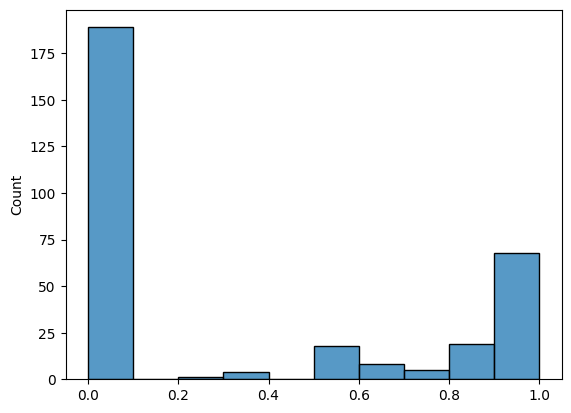

In [206]:
sns.histplot(probability_predictions[:,1])

In [162]:
log_loss_value = log_loss(y_test, probability_predictions[:,1])
print(f'Log Loss: {log_loss_value}')

Log Loss: 0.16254723644774124


In [163]:
roc_auc = roc_auc_score(y_test, probability_predictions[:,1])
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.992096185064935


In [164]:
class_report = classification_report(y_test, class_predictions)
print(f'Classification Report:\n {class_report}')

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97       308
           1       0.97      0.91      0.94       160

    accuracy                           0.96       468
   macro avg       0.96      0.95      0.95       468
weighted avg       0.96      0.96      0.96       468



Возможно, KNN на данных с низкой вариативностью работает с подвохом. Precision и recall скачет на +-7 в зависимости от random_seed. Возможно, увеличение датасета улучшило бы ситуацию


## Итоговая модель


In [5]:
df_knn = df[['Общее_Болевой синдром',
         'УЗИ брюшной полости_диурез',
         'УЗИ брюшной полости_объем выпота',
         'Осложнения, возникшие на этапе лечения']]


X = df_knn.drop([global_target_col_name], axis=1)
y = df_knn[global_target_col_name]


In [6]:
knn_pipe = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_jobs=-1))]
)

In [7]:
param_grid = [
    { 'knn__n_neighbors' : [i for i in range(15,40)],
      'knn__weights' : ['uniform','distance'],
      'knn__metric' : ['euclidean','manhattan','cosine'],
    }
]

In [8]:
random_search = RandomizedSearchCV(estimator=knn_pipe, 
                           param_distributions=param_grid, 
                           n_iter=500,
                           scoring='roc_auc', 
                           refit='roc_auc', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=5)

random_search.fit(X, y)

C:\Users\Daniil\Desktop\DS projects\DS_peritonit\my_env\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 150 is smaller than n_iter=500. Running 150 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 150 candidates, totalling 750 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn',
                                              KNeighborsClassifier(n_jobs=-1))]),
                   n_iter=500, n_jobs=-1,
                   param_distributions=[{'knn__metric': ['euclidean',
                                                         'manhattan',
                                                         'cosine'],
                                         'knn__n_neighbors': [15, 16, 17, 18,
                                                              19, 20, 21, 22,
                                                              23, 24, 25, 26,
                                                              27, 28, 29, 30,
                                                              31, 32, 33, 34,
                                                              35, 36, 37, 38,
                                                              39],
                                         'knn__weights': ['uniform',
                                                          'distance']}],
                   refit='roc_auc', scoring='roc_auc', verbose=5)

In [9]:
random_search.best_params_

{'knn__weights': 'uniform', 'knn__n_neighbors': 39, 'knn__metric': 'manhattan'}

In [10]:
random_search.best_score_

0.973564607633346

In [12]:
probability_predictions = random_search.best_estimator_.predict_proba(X)

<Axes: ylabel='Count'>

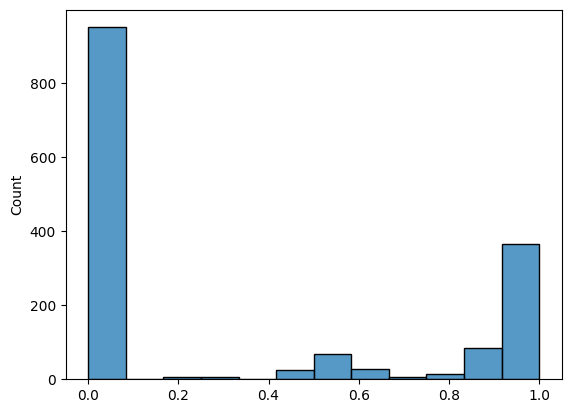

In [13]:
sns.histplot(probability_predictions[:,1])

In [17]:
random_search.best_estimator_.predict_proba([[0, 1000, 100]])

C:\Users\Daniil\Desktop\DS projects\DS_peritonit\my_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.97435897, 0.02564103]])

In [215]:
with open('SRG_model_knn.pkl', 'wb') as file:
    pickle.dump(random_search.best_estimator_, file)

## GBDT


In [138]:
df_gbdt = df[['Общее_Болевой синдром',
         'УЗИ брюшной полости_диурез',
         'УЗИ брюшной полости_объем выпота',
         'Осложнения, возникшие на этапе лечения',
        "Общее_Возраст",
        "Общее_Характер перитонита_диффузный",
        "Общее_Характер перитонита_местный",
        "Общее_Характер перитонита_распространенный",
        "УЗИ брюшной полости_Размеры печени1",
        "УЗИ брюшной полости_Размеры печени2",
        "УЗИ брюшной полости_Узи почек1",
        "УЗИ брюшной полости_Узи почек2",
        "УЗИ брюшной полости_фибрин",
        "УЗИ брюшной полости_спайки"]]


In [139]:
X = df_gbdt.drop([global_target_col_name], axis=1)
y = df_gbdt[global_target_col_name]


In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42, shuffle=True) 

##### KPCA


In [95]:
x_tr = X_train['Общее_Болевой синдром']
x_te = X_test['Общее_Болевой синдром']

X_train = X_train.drop('Общее_Болевой синдром', axis = 1)
X_test = X_test.drop('Общее_Болевой синдром', axis = 1)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

kpca = KernelPCA(n_components = 3, kernel = 'rbf')
X_train = kpca.fit_transform(X_train)
X_test = kpca.transform(X_test)

X_train = np.insert(X_train, 0, list(x_tr), axis=1)
X_test = np.insert(X_test, 0, list(x_te), axis=1)

In [96]:
boost_model = HistGradientBoostingClassifier(max_iter=100, early_stopping=True)

In [97]:
param_grid = [
    {"learning_rate": stats.loguniform(10**(-3), 10**1),
     "max_depth": [i for i in range(2,11)],
     'l2_regularization': stats.loguniform(10**(-2), 10**3),
     "max_leaf_nodes": [i for i in range(2,100)],
     "min_samples_leaf": [i for i in range(1,100)],
     'class_weight': [None, 'balanced']
    }
]

In [98]:
random_search = RandomizedSearchCV(estimator=boost_model, 
                           param_distributions=param_grid, 
                           n_iter=1000,
                           scoring='roc_auc', 
                           refit='roc_auc', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=5)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


RandomizedSearchCV(cv=5,
                   estimator=HistGradientBoostingClassifier(early_stopping=True),
                   n_iter=1000, n_jobs=-1,
                   param_distributions=[{'class_weight': [None, 'balanced'],
                                         'l2_regularization': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AF8A590A90>,
                                         'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AF8A673370>,
                                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                       10],
                                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8,
                                                            9, 10, 11, 12, 13,
                                                            14, 15, 16, 17, 18,
                                                            19, 20, 21, 22, 23,
                                                            24, 25, 26, 27, 28,
                                                            29, 30, 31, ...],
                                         'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                              12, 13, 14, 15,
                                                              16, 17, 18, 19,
                                                              20, 21, 22, 23,
                                                              24, 25, 26, 27,
                                                              28, 29, 30, ...]}],
                   refit='roc_auc', scoring='roc_auc', verbose=5)

In [99]:
random_search.best_params_

{'class_weight': None,
 'l2_regularization': 6.410565316856578,
 'learning_rate': 0.18576180860118838,
 'max_depth': 9,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 1}

In [100]:
random_search.best_score_

0.9885950176079301

In [101]:
random_search.best_estimator_.n_iter_

100

In [102]:
class_predictions = random_search.best_estimator_.predict(X_test)
probability_predictions = random_search.best_estimator_.predict_proba(X_test)

<Axes: ylabel='Count'>

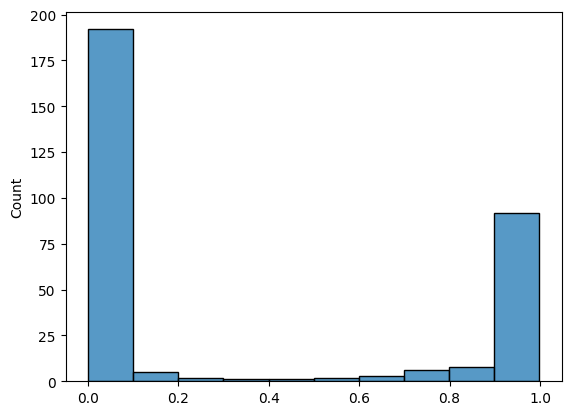

In [124]:
sns.histplot(probability_predictions[:,1])

In [125]:
pd.DataFrame(probability_predictions[:,1]).value_counts()

0.000949    9
0.000947    8
0.001297    5
0.000941    5
0.000881    5
           ..
0.006971    1
0.007168    1
0.007277    1
0.007362    1
0.998004    1
Name: count, Length: 238, dtype: int64

In [104]:
log_loss_value = log_loss(y_test, probability_predictions[:,1])
print(f'Log Loss: {log_loss_value}')

Log Loss: 0.17338121728275327


In [105]:
roc_auc = roc_auc_score(y_test, probability_predictions[:,1])
print(f'ROC AUC: {roc_auc}')

ROC AUC: 0.9806473672213356


In [106]:
class_report = classification_report(y_test, class_predictions)
print(f'Classification Report:\n {class_report}')

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       205
           1       0.90      0.93      0.92       107

    accuracy                           0.94       312
   macro avg       0.93      0.94      0.94       312
weighted avg       0.94      0.94      0.94       312



У GBDT после понижения размерности проблем с вариативностью быть не должно. 


In [140]:
xx = X['Общее_Болевой синдром']


X = X.drop('Общее_Болевой синдром', axis = 1)


sc = StandardScaler()
X = sc.fit_transform(X)

kpca = KernelPCA(n_components = 3, kernel = 'rbf')
X = kpca.fit_transform(X)

X = np.insert(X, 0, list(xx), axis=1)


In [141]:
X

array([[ 1.        ,  0.14369161, -0.43606681, -0.2437926 ],
       [ 1.        , -0.40840156, -0.23555843,  0.05610815],
       [ 0.        , -0.15426591, -0.19067798,  0.11556541],
       ...,
       [ 0.        ,  0.33602828, -0.0159717 , -0.0353716 ],
       [ 0.        ,  0.37408342,  0.05931079,  0.05832148],
       [ 1.        , -0.30397581,  0.05760485,  0.1345805 ]])

In [142]:
boost_model = HistGradientBoostingClassifier(max_iter=100, early_stopping=True)

In [143]:
param_grid = [
    {"learning_rate": stats.loguniform(10**(-3), 10**1),
     "max_depth": [i for i in range(2,5)],
     'l2_regularization': stats.loguniform(10**(-2), 10**3),
     "max_leaf_nodes": [i for i in range(2,100)],
     "min_samples_leaf": [i for i in range(1,100)],
     'class_weight': [None, 'balanced']
    }
]

In [144]:
random_search = RandomizedSearchCV(estimator=boost_model, 
                           param_distributions=param_grid, 
                           n_iter=1500,
                           scoring='roc_auc', 
                           refit='roc_auc', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=5)

random_search.fit(X, y)

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


RandomizedSearchCV(cv=5,
                   estimator=HistGradientBoostingClassifier(early_stopping=True),
                   n_iter=1500, n_jobs=-1,
                   param_distributions=[{'class_weight': [None, 'balanced'],
                                         'l2_regularization': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AF8BF9C160>,
                                         'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001AF8BF9D120>,
                                         'max_depth': [2, 3, 4],
                                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8,
                                                            9, 10, 11, 12, 13,
                                                            14, 15, 16, 17, 18,
                                                            19, 20, 21, 22, 23,
                                                            24, 25, 26, 27, 28,
                                                            29, 30, 31, ...],
                                         'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10, 11,
                                                              12, 13, 14, 15,
                                                              16, 17, 18, 19,
                                                              20, 21, 22, 23,
                                                              24, 25, 26, 27,
                                                              28, 29, 30, ...]}],
                   refit='roc_auc', scoring='roc_auc', verbose=5)

In [145]:
random_search.best_params_

{'class_weight': None,
 'l2_regularization': 0.012915093275397594,
 'learning_rate': 0.025988277067486073,
 'max_depth': 3,
 'max_leaf_nodes': 92,
 'min_samples_leaf': 41}

In [146]:
random_search.best_score_

0.9838681483406588

In [147]:
random_search.best_estimator_.n_iter_

100

In [2]:
import pickle

In [56]:
with open('SRG_model.pkl', 'wb') as file:
    pickle.dump(random_search.best_estimator_, file)

with open('SRG_scaler.pkl', 'wb') as file:
    pickle.dump(sc, file)

with open('SRG_kpca.pkl', 'wb') as file:
    pickle.dump(kpca, file)



In [3]:
# Load from file
with open('SRG_model_knn.pkl', 'rb') as file:
    model = pickle.load(file)

with open('SRG_kpca.pkl', 'rb') as file:
    pca = pickle.load(file)

with open('SRG_scaler.pkl', 'rb') as file:
    sc = pickle.load(file)

In [6]:
model.predict_proba([[0,1000,100]])

C:\Users\Даниил\OneDrive\Рабочий стол\Peritonit\my_env\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([[0.97435897, 0.02564103]])